## 07 Time Series Model

Finally, it is time to cut to the chase! In the following, I will estimate a VAR-model to establish whether mainstream parrty communication on immigration affects polling results of the AfD, whether it's the other way around or whether both is related to public interest in immigration.

In [1]:
import dropbox
import os.path
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa as smtsa
import numpy as np
from pandas.tseries.offsets import BDay
%matplotlib inline

basedir = os.path.expanduser('~/Dropbox/Studies/Semester 2/Block I/data_IMEM/')

I load and prepare the data...

In [2]:
data = pd.read_csv(basedir+'full_ts.csv')
data.index = pd.DatetimeIndex(data['Unnamed: 0'])
data = data.drop(['Unnamed: 0'], axis = 1)

data.columns = ['afd', 'mp_com', 'spd', 'cdu', 'salience']

def f(x):
    return np.int(x)
f2 = np.vectorize(f)

data['nickelsdorf'] = f2(data.index >= '2015-08-01')
data['aug15'] = f2(data.index == '2015-08-01')

To estimate time series, it is necessary that the series are stationary, i.e. they show no trend over time. We can check this employing the Dickey-Fuller test:

In [3]:
for col in data:
    print(col, ':', round(sm.tsa.stattools.adfuller(data[col])[1], 3))

afd : 0.362
mp_com : 0.001
spd : 0.0
cdu : 0.237
salience : 0.002
nickelsdorf : 0.641
aug15 : 0.0


While two of three series show no trend, the test is insignificant for the series on afd polling (interpret the number like a p-value, H0: series has a trend/is non-stationary). To avoid confusion in later interpretations, I will difference all series.

In [4]:
data_dif = data
for col in data[['afd', 'mp_com', 'spd', 'cdu', 'salience']]:
    data_dif[col] = data[col].diff()
    
data_dif = data_dif[1:]
for col in data_dif:
    print(col, ':', round(sm.tsa.stattools.adfuller(data_dif[col])[1], 3))

afd : 0.002
mp_com : 0.0
spd : 0.0
cdu : 0.0
salience : 0.0
nickelsdorf : 0.63
aug15 : 0.0


Since now none of the series (except the dummy) shows a trend, we can move on to estimate a model! I hypothesise that it is unlikely that lags last longer than one year. Remember that H1 posited that AfD polling results are dependent on mainstream party communication on immigration. H2 stated that mainstream parties' attention to immigration is driven by the AfD's electoral share. Hence my first model will look at the link between AfD polling and mainstream party communication on immigration. 

To identify the correct lag, I look at fit statistics across all models from lag(0) to lag(12):

In [5]:
data_sub = data_dif[['afd', 'mp_com']]
model1 = sm.tsa.VAR(data_sub)
print(model1.select_order(12).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.07     -16.00*   1.054e-07     -16.04*
1       -16.08      -15.88   1.034e-07      -16.00
2       -16.02      -15.67   1.103e-07      -15.88
3      -16.10*      -15.62  1.021e-07*      -15.91
4       -16.05      -15.43   1.072e-07      -15.81
5       -15.98      -15.22   1.152e-07      -15.69
6       -15.92      -15.02   1.231e-07      -15.57
7       -15.84      -14.80   1.354e-07      -15.43
8       -15.75      -14.58   1.483e-07      -15.29
9       -15.88      -14.56   1.325e-07      -15.36
10      -15.80      -14.35   1.454e-07      -15.23
11      -15.80      -14.21   1.481e-07      -15.18
12      -15.71      -13.98   1.660e-07      -15.04
--------------------------------------------------


C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


The minima of the fit statistics point to a lag of three.

In [6]:
results1 = model1.fit(3)
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct, 2019
Time:                     15:08:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.7564
Nobs:                     70.0000    HQIC:                  -16.0275
Log likelihood:           382.562    FPE:                9.17000e-08
AIC:                     -16.2061    Det(Omega_mle):     7.57851e-08
--------------------------------------------------------------------
Results for equation afd
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.001136         0.001145            0.993           0.321
L1.afd            0.338507         0.123771            2.735           0.006
L1.mp_com        -0.008467         0.036373           -0.233           0.816
L

Surprisingly, the effect of the lagged value of the fraction of mainstream parties' press releases devoted to immigration on AfD polling results is as far from significant as it gets. Similarly, the effect of the AfD vote share on immigration communication by the mainstream parties is insignificant and *negative*. If there is any effect of AfD success in this model, it discourages mainstream party communication on immigration!

It seems H1 and H2 cannot be confirmed. However, maybe there is an effect in a model with public issue salience, which might affect both variables. Additionally, according to H3, mainstream parties’ devotion to immigration is driven by public salience
of the issue and H4 claims that AfD success is dependent on public salience of immigration. We will check all three possibilities in a three-way-VAR-model:

In [7]:
# model selection
data_sub = data_dif[['afd', 'salience', 'mp_com']]
model2 = sm.tsa.VAR(data_sub)
print(model2.select_order(12).summary()) # looks like 1

results2 = model2.fit(1)

print(results2.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.56      -20.46   1.175e-09      -20.52
1       -20.88     -20.47*   8.547e-10     -20.72*
2       -20.92      -20.20  8.224e-10*      -20.64
3       -20.83      -19.79   9.043e-10      -20.43
4       -20.68      -19.33   1.066e-09      -20.15
5       -20.53      -18.87   1.257e-09      -19.88
6       -20.38      -18.41   1.498e-09      -19.61
7       -20.43      -18.14   1.487e-09      -19.53
8       -20.29      -17.70   1.796e-09      -19.27
9       -20.33      -17.42   1.847e-09      -19.19
10      -20.23      -17.01   2.237e-09      -18.97
11     -21.09*      -17.56   1.064e-09      -19.71
12      -20.99      -17.15   1.366e-09      -19.49
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct

C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


A lag of one month seems appropriate here, according to the model fit. Firstly, AfD-success seems not to be affected by public salience of immigration nor by mainstream parties' communication on the issue - H1 and H4 can be laid to rest. Public salience of the issue is not affected by AfD-success, but it is positively affected by mainstream parties' communication (p < 0.05)! Although this was not part of the expected outcomes, I will look further into this later on. Lastly, mainstream parties' attention to immigration is not affected by the AfD's electoral gains and losses (goodbye, H2!), but it is *negatively* affected by public salience of the issue with a lag of one month (p < 0.05; H3 to the trash)!

To inspect the relationship between public attention to immigration and mainstream parties' communication on the issue more closely, I will look at the VAR-model excluding AfD polling and employ a Granger causality test. Granger causality is satisfied when a time series' prediction based on its own past can be significantly improved by adding the past of another variable to the predictors.

In [8]:
data_sub = data_dif[['salience', 'mp_com']]
model3 = sm.tsa.VAR(data_sub)
print(model3.select_order(12).summary()) # looks like 2

results3 = model3.fit(2)
print(results3.summary())

C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.28      -11.21   1.261e-05      -11.25
1       -11.63      -11.42   8.936e-06      -11.54
2       -11.78     -11.43*   7.662e-06     -11.64*
3       -11.76      -11.27   7.843e-06      -11.57
4       -11.67      -11.05   8.542e-06      -11.43
5       -11.56      -10.80   9.634e-06      -11.26
6       -11.50      -10.60   1.023e-05      -11.15
7       -11.62      -10.59   9.130e-06      -11.22
8       -11.53      -10.35   1.016e-05      -11.07
9       -11.45      -10.14   1.107e-05      -10.94
10      -11.42      -9.962   1.169e-05      -10.85
11     -11.93*      -10.34  7.124e-06*      -11.31
12      -11.90      -10.17   7.485e-06      -11.23
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct

In [9]:
print("MP emphasis <-> salience; two-month lag:\n")
print(results3.test_causality('mp_com', 'salience').summary())
print(results3.test_causality('salience', 'mp_com').summary())

MP emphasis <-> salience; two-month lag:

Granger causality F-test. H_0: salience does not Granger-cause mp_com. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
    4.542          3.065       0.012  (2, 132)
----------------------------------------------
Granger causality F-test. H_0: mp_com does not Granger-cause salience. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
    4.815          3.065       0.010  (2, 132)
----------------------------------------------


We can see that the Granger-test is significant in both instances: public attention to immigration *decreases* the likelihood that parties communicate about immigration, while mainstream parties seem to be able to manipulate public attention to an issue by sending press releases - and that is what they are for.

## Visualisations

### Impulse response functions

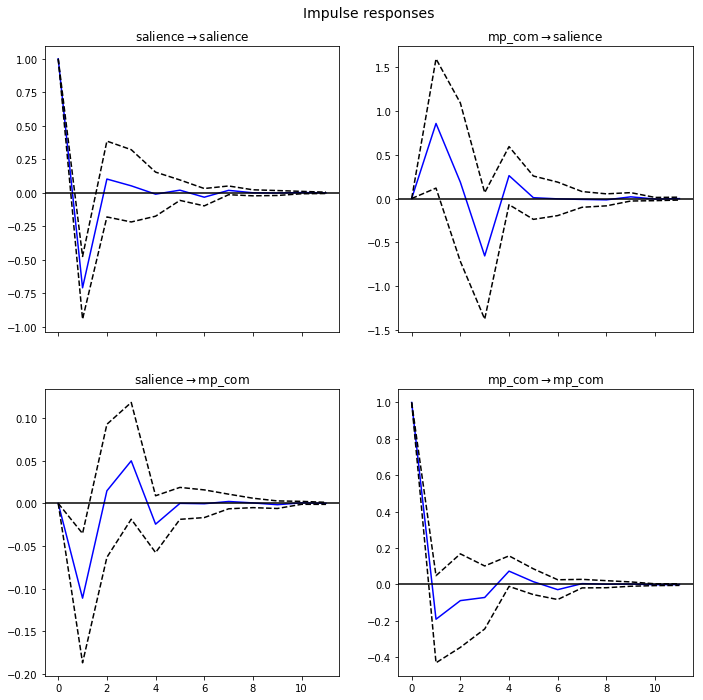

In [10]:
irf = results3.irf(11)
plot1 = irf.plot()

## Robustness tests

### split sample before/after refugees were transported from Hungary to Austria and Germany in August 2015

In [11]:
# create split samples before/after August 2015
sample_bf = data_dif[data_dif['nickelsdorf'] == 0]
sample_af = data_dif[data_dif['nickelsdorf'] == 1]

In [12]:
# estimate restricted model before August 2015
data_sub = sample_bf[['afd', 'mp_com']]
model_bf = sm.tsa.VAR(data_sub)
print(model_bf.select_order(6).summary())

results_bf = model_bf.fit(1)
print(results_bf.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -16.66     -16.56*   5.827e-08      -16.64
1     -16.85*      -16.56  4.811e-08*     -16.79*
2      -16.69      -16.20   5.735e-08      -16.58
3      -16.46      -15.77   7.465e-08      -16.31
4      -16.21      -15.31   1.031e-07      -16.01
5      -16.19      -15.09   1.176e-07      -15.95
6      -16.31      -15.01   1.258e-07      -16.03
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct, 2019
Time:                     15:08:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.4848
Nobs:                     26.0000    HQIC:                  -16.6916
Log likelihood:           150.292    FPE:                5.19443e-08

C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [13]:
# estimate restricted model after August 2015
data_sub = sample_af[['afd', 'mp_com']]
model_af = sm.tsa.VAR(data_sub)
print(model_af.select_order(12).summary())

results_af = model_af.fit(1)
print(results_af.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.83      -16.74   4.888e-08      -16.80
1      -17.06*     -16.79*  3.919e-08*     -16.96*
2       -16.90      -16.46   4.573e-08      -16.75
3       -16.87      -16.24   4.790e-08      -16.65
4       -16.68      -15.87   5.835e-08      -16.41
5       -16.67      -15.69   6.022e-08      -16.34
6       -16.59      -15.42   6.760e-08      -16.19
7       -16.37      -15.03   8.836e-08      -15.91
8       -16.39      -14.86   9.273e-08      -15.87
9       -16.31      -14.60   1.102e-07      -15.73
10      -16.24      -14.35   1.345e-07      -15.59
11      -16.49      -14.42   1.238e-07      -15.78
12      -16.47      -14.23   1.595e-07      -15.71
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct

C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### include event control for August 2015

In [14]:
data_sub = data_dif[['afd', 'mp_com', 'aug15']]
model_ec = sm.tsa.VAR(data_sub)
print(model_ec.select_order(12).summary()) # looks like 2

results_ec = model_ec.fit(3)
print(results_ec.summary())



 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.42     -20.32*   1.356e-09     -20.38*
1       -20.45      -20.04   1.312e-09      -20.29
2       -20.42      -19.69   1.361e-09      -20.13
3      -20.53*      -19.49  1.229e-09*      -20.12
4       -20.44      -19.09   1.353e-09      -19.91
5       -20.41      -18.75   1.424e-09      -19.76
6       -20.28      -18.31   1.659e-09      -19.51
7       -20.24      -17.96   1.793e-09      -19.35
8       -20.06      -17.46   2.270e-09      -19.04
9       -20.14      -17.24   2.232e-09      -19.00
10      -20.04      -16.83   2.694e-09      -18.78
11      -20.09      -16.56   2.883e-09      -18.71
12      -20.18      -16.34   3.079e-09      -18.67
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct

C:\Users\samunico\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


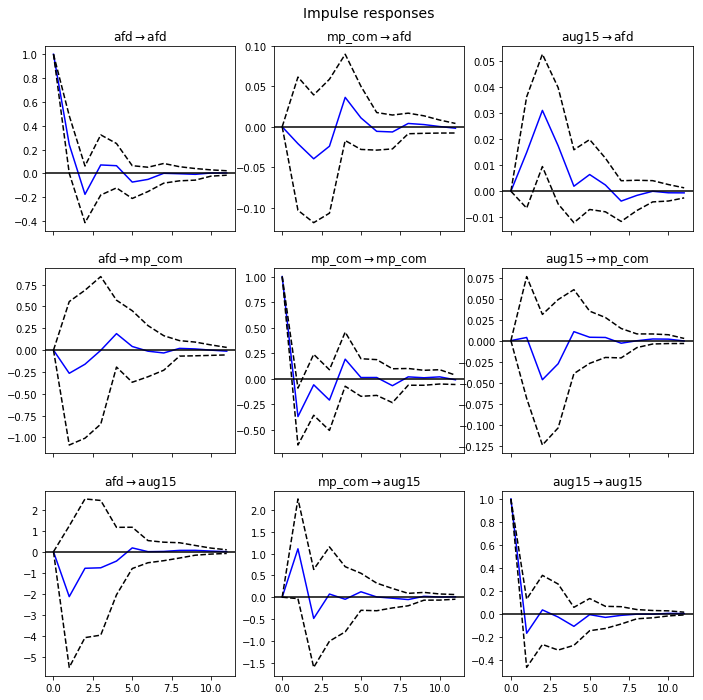

In [15]:
irf = results_ec.irf(11)
plot3 = irf.plot()

### CDU/CSU communication only

In [16]:
data_sub = data_sub_b[['afd', 'cdu']]
model_cdu = sm.tsa.VAR(data_sub)
print(model_cdu.select_order(12).summary())

NameError: name 'data_sub_b' is not defined

In [ ]:
results_cdu = model_cdu.fit(3)
results_cdu.summary() # no effect

## eleven-month lag for MP emphasis <-> salience model

In [ ]:
results4 = model3.fit(11)
print(results4.summary())
print("\n\nMP emphasis <-> salience; eleven-month lag:\n")
print(results4.test_causality('mp_com', 'salience').summary())
print(results4.test_causality('salience', 'mp_com').summary())